In [ ]:
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from geometry import angle_matrix

%matplotlib inline

In [2]:
# eval_manager = EvalManager(verbosity=0)
# eval_manager.load_samples('saved/im_phototourism_notre_dame_front_facade_samples.joblib')
# eval_manager.load_results('results/im_phototourism_notre_dame_front_facade_samples.joblib')
#
# eval_manager_2 = EvalManager(verbosity=0)
# eval_manager_2.load_samples('saved/im_phototourism_lincoln_memorial_statue_samples.joblib')
# eval_manager_2.load_results('results/im_phototourism_lincoln_memorial_statue_samples.joblib')


In [3]:
from eval.uncal import SemiManager

dataset_path = 'D:/Research/data/ImageMatching2023/phototourism'
basename = os.path.basename(dataset_path)

dir_list = [x for x in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, x))]

eval_managers = []
for subset in dir_list:
    eval_manager = SemiManager(verbosity=0)
    eval_manager.load_samples('saved/im_{}_{}_samples.joblib'.format(basename, subset))
    eval_manager.load_results('results/im_{}_{}_samples.joblib'.format(basename, subset))
    eval_managers.append(eval_manager)

In [53]:
from scipy.stats import pearsonr
from geometry import line_distance
from scipy.spatial.transform import Rotation
import xicorpy

def corrcoef_loop(y, x):
    feats = len(x)
    r = np.ones(feats)
    p = np.ones(feats)
    for j in range(feats):
        # r_, p_ = pearsonr(matrix[0], matrix[j])
        r_, p_ = xicorpy.compute_xi_correlation(y, x[j], get_p_values=True, get_modified_xi=False)
        r[j] = r_
        p[j] = p_
    return r, p


def analysis_plot(mgrs):
    f_1s = []
    f_2s = []
    svd_errs = []
    direct_errs = []
    minimal_errs = []
    depths = []

    line_distances = []
    center_distances = []
    angles = []
    plane_angles = []
    num_corrs = []

    for mgr in mgrs:
        for i, sample in enumerate(mgr.samples):
            kp_1, kp_2, f_1, f_2, img_shape_1, img_shape_2, cam_1, cam_2, img_1, img_2, X = sample
            svd_errs.append(mgr.errors['svd'][2 * i])
            direct_errs.append(mgr.errors['direct'][2 * i])
            minimal_errs.append(mgr.errors['minimal'][2 * i])

            pca = PCA(n_components=3)
            pca.fit(np.array(X))
            depths.append(pca.explained_variance_ratio_[2])

            q_1 = (img_1['q'])
            R_1 = Rotation.from_quat([q_1[1], q_1[2], q_1[3], q_1[0]]).as_matrix()
            # R_1 = Rotation.from_quat(q_1).as_matrix()
            t_1 = img_1['t']
            q_2 = (img_2['q'])
            R_2 = Rotation.from_quat([q_2[1], q_2[2], q_2[3], q_2[0]]).as_matrix()
            # R_2 = Rotation.from_quat(q_2).as_matrix()
            t_2 = img_2['t']

            R = R_1.T @ R_2
            t = R_1.T @ (t_2 - t_1)
            c = -R.T @ t

            p_dir = R.T @ np.array([0, 0, 1])

            num_corrs.append(len(kp_1))

            n_plane = np.cross(np.array([0, 0, 1]), c)

            plane_angles.append(np.pi / 2 - np.arccos(np.abs(np.dot(n_plane, p_dir)) / (np.linalg.norm(n_plane)* np.linalg.norm(p_dir))))

            d = line_distance(np.zeros(3), np.array([0, 0, 1]), c, p_dir)
            line_distances.append(np.abs(d))
            center_distances.append(np.linalg.norm(c))


            angles.append(angle_matrix(R))

            f_1s.append(f_1)
            f_2s.append(f_2)

    svd_errs = np.array(svd_errs)
    direct_errs = np.array(direct_errs)
    minimal_errs = np.array(minimal_errs)

    svd_errs[np.isnan(svd_errs)] = 1.0
    direct_errs[np.isnan(direct_errs)] = 1.0
    minimal_errs[np.isnan(minimal_errs)] = 1.0

    X = np.row_stack([depths, num_corrs, angles, plane_angles, line_distances, center_distances, f_1s, f_2s, np.array(f_1s) / np.array(f_2s)])



    r, p = corrcoef_loop(direct_errs, X)
    print("Direct")
    print(r)
    print(p)

    r, p = corrcoef_loop(svd_errs, X)
    print("SVD")
    print(r)
    print(p)

    r, p = corrcoef_loop(svd_errs - direct_errs, X)
    print("SVD - Direct")
    print(r)
    print(p)

    r, p = corrcoef_loop(svd_errs - direct_errs, np.row_stack([f_1s, f_2s, np.array(f_1s) / np.array(f_2s)]))
    # r = xicorpy.compute_conditional_dependence(svd_errs, np.column_stack([f_1s, f_2s, direct_errs]))
    print("SVD - Direct")
    print(r)
    print(p)

    r, p = corrcoef_loop(minimal_errs - direct_errs, X)
    print("Minimal - Direct")
    print(r)
    print(p)

    r = corrcoef_loop(minimal_errs - svd_errs, X)

    print("Minimal - SVD")
    print(r)
    print(p)

    # plt.figure()
    # plt.plot(distances, svd_errs - direct_errs, '*', label='svd')
    # print(np.corrcoef(f_2s, svd_errs - direct_errs))
    # plt.show()
    # plt.figure()
    # plt.plot(distances, minimal_errs - direct_errs, '*', label='direct')
    # print(np.corrcoef(distances, minimal_errs - direct_errs))
    # # plt.plot(f_1s, minimal_errs, '*', label='minimal')
    # plt.show()

    # plt.figure()
    # plt.plot(f_2s, svd_errs, '*', label='svd')
    # plt.plot(f_2s, direct_errs, '*', label='direct')
    # plt.plot(f_2s, minimal_errs, '*', label='minimal')
    # plt.show()
analysis_plot(eval_managers)

Direct
[-0.01822329  0.01288173 -0.00019532  0.00759682  0.00375433 -0.0061795
 -0.01353351  0.01682748  0.01602339]
[0.94273802 0.13228019 0.50674802 0.25529956 0.37253974 0.70373072
 0.87941078 0.07251503 0.08261935]
SVD
[ 0.00550322 -0.02167909  0.00055567 -0.03189679 -0.00894233  0.02345252
 -0.01788893 -0.00475329 -0.01070026]
[0.31682608 0.96978275 0.48080922 0.99713063 0.78066138 0.021125
 0.93933795 0.65970194 0.82295096]
SVD - Direct
[-0.0111629  -0.00263448  0.00538099 -0.01299815  0.00511499 -0.0010615
  0.01314267 -0.00187872  0.01534739]
[0.83316163 0.59024298 0.32060508 0.86984829 0.32889323 0.53662258
 0.12751885 0.56462389 0.09190371]
SVD - Direct
[ 0.01314267 -0.00187872  0.01534739]
[0.12751885 0.56462389 0.09190371]
Minimal - Direct
[ 0.00327321  0.00849998  0.01130397 -0.0029165  -0.008485    0.02170885
  0.00855391  0.00529453 -0.0005126 ]
[0.38840913 0.23081157 0.1638017  0.59970218 0.76877624 0.0300511
 0.22940825 0.32328824 0.5177042 ]
Minimal - SVD
(array([ 0.0

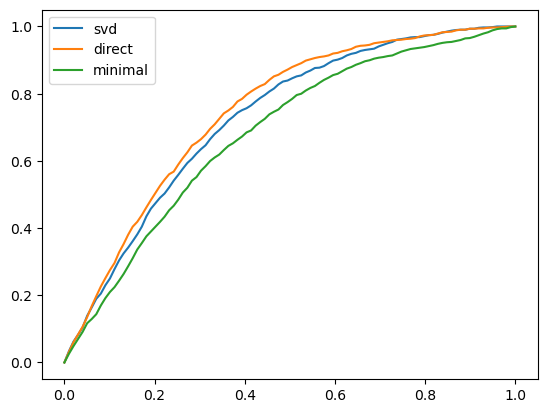

In [63]:
def plane_angle_plot(mgrs):
    f_1s = []
    f_2s = []
    depths = []

    svd_errs = []
    direct_errs = []
    minimal_errs = []

    for mgr in mgrs:


        for i, sample in enumerate(mgr.samples):
            kp_1, kp_2, f_1, f_2, img_shape_1, img_shape_2, cam_1, cam_2, img_1, img_2, X = sample


            q_1 = (img_1['q'])
            R_1 = Rotation.from_quat([q_1[1], q_1[2], q_1[3], q_1[0]]).as_matrix()
            # R_1 = Rotation.from_quat(q_1).as_matrix()
            t_1 = img_1['t']
            q_2 = (img_2['q'])
            R_2 = Rotation.from_quat([q_2[1], q_2[2], q_2[3], q_2[0]]).as_matrix()
            # R_2 = Rotation.from_quat(q_2).as_matrix()
            t_2 = img_2['t']
            R = R_1.T @ R_2
            t = R_1.T @ (t_2 - t_1)
            c = -R.T @ t
            p_dir = R.T @ np.array([0, 0, 1])
            n_plane = np.cross(np.array([0, 0, 1]), c)
            plane_angle = np.pi / 2 - np.arccos(np.abs(np.dot(n_plane, p_dir)) / (np.linalg.norm(n_plane)* np.linalg.norm(p_dir)))

            # if len(kp_1) > 10:
            # if 180 * plane_angle / np.pi > 10:
            # if f_2 / f_1 < 1.2 or f_2 / f_1 > 0.8:
            if np.linalg.norm(c) < 3.0:
            # if True:
                svd_errs.append(mgr.errors['svd'][2 * i])
                # svd_errs.append(mgr.errors['svd'][2 * i + 1])
                direct_errs.append(mgr.errors['direct'][2 * i])
                # direct_errs.append(mgr.errors['direct'][2 * i + 1])
                minimal_errs.append(mgr.errors['minimal'][2 * i])
                # minimal_errs.append(mgr.errors['minimal'][2 * i + 1])


    x = np.linspace(0, 1.0, 100)
    svd_res = np.array([np.sum(svd_errs < t)/len(svd_errs) for t in x])
    direct_res = np.array([np.sum(direct_errs < t)/len(direct_errs) for t in x])
    minimal_res = np.array([np.sum(minimal_errs < t)/len(minimal_errs) for t in x])

    plt.plot(x, svd_res, label='svd')
    plt.plot(x, direct_res, label='direct')
    plt.plot(x, minimal_res, label='minimal')
    plt.legend()
    plt.show()

plane_angle_plot(eval_managers)